In [1]:
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os
from os import listdir
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from dataloader_teeth_forc import *
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.nn import *

In [2]:
# class SELayer(nn.Module):
#     def __init__(self, channel, reduction=16):
#         super(SELayer, self).__init__()
#         self.max_pool = AdaptiveMaxPool2d(1)
#         self.fc = nn.Sequential(
#             Linear(channel, channel // reduction, bias=False),
#             ReLU(inplace=True),
#             Linear(channel // reduction, channel, bias=False),
#             Sigmoid()
#         )

#     def forward(self, x):
#         b, c, _, _ = x.size()
#         y = self.max_pool(x).view(b, c)
#         y = self.fc(y).view(b, c, 1, 1)
#         return x * y.expand_as(x)

# class DeepConvNet(torch.nn.Module):
#     def __init__(self, act_fn='ReLU'):
#         super().__init__()
        
#         dropout = 0.3
#         self.conv0 = Conv2d(1, 32, kernel_size=(3, 3))
#         self.conv1 = Conv2d(32, 32, kernel_size=(3, 3))
        
#         self.se1 = SELayer(32, 16)
#         self.se2 = SELayer(64, 16)
#         self.se3 = SELayer(128, 16)
#         self.se4 = SELayer(256, 16)
        
#         self.layer1 = Sequential(
#             BatchNorm2d(32),
#             self.activationFunc(act_fn),
#             MaxPool2d(kernel_size=(2, 2)),
#             Dropout2d(dropout)
#         )

#         self.conv2 = Conv2d(32, 64, kernel_size=(3, 3))
#         self.layer2 = Sequential(
#             BatchNorm2d(64),
#             self.activationFunc(act_fn),
#             MaxPool2d(kernel_size=(2, 2)),
#             Dropout(dropout)
#         )
        
#         self.conv3 = Conv2d(64, 128, kernel_size=(3, 3))
#         self.layer3 = Sequential(
#             BatchNorm2d(128),
#             self.activationFunc(act_fn),
#             MaxPool2d(kernel_size=(2, 2)),
#             Dropout(dropout)
#         )
        
#         self.conv4 = Conv2d(128, 256, kernel_size=(3, 3))
#         self.layer4 = Sequential(
#             BatchNorm2d(256),
#             self.activationFunc(act_fn),
#         )
        
#         self.maxpool = Sequential(
#             MaxPool2d(kernel_size=(2, 2)),
#             Dropout(dropout)
#         )  

#         self.classify = Sequential(
#             Linear(in_features=5376,out_features=3)
#         )


#     def activationFunc(self, act_fn):
#         if act_fn == 'ReLU':
#             return ReLU()
#         elif act_fn == 'LReLU':
#             return LeakyReLU()
#         else:
#             return ELU()
        
#     def activations_hook(self, grad):
#         self.gradients = grad
        
#     def forward(self, x):
#         x = self.conv0(x)
#         x = self.conv1(x)
        
#         x1 = self.se1(x)
#         x = x + x1
        
#         x = self.layer1(x)
#         x = self.conv2(x)
        
#         x1 = self.se2(x)
#         x = x + x1        
        
#         x = self.layer2(x)
#         x = self.conv3(x)
        
#         x1 = self.se3(x)
#         x = x + x1
        
#         x = self.layer3(x)
#         x = self.conv4(x)
        
#         x1 = self.se4(x)
#         x = x + x1
        
#         x = self.layer4(x)
        
#         h = x.register_hook(self.activations_hook)
        
        
#         x = self.maxpool(x)
#         #print(x.size())
#         x = x.view(-1, 5376) # 當bug為 tensor_a(4).....tensor_b(8) -> //2 ->476800//2 (150,200)
#         #print('size =',x.size())
#         x = self.classify(x)
#         #print('final size =',x.size())
#         return x
    
#     # method for the gradient extraction
#     def get_activations_gradient(self):
#         return self.gradients
    
#     # method for the activation exctraction
#     def get_activations(self, x):
#         x = self.conv0(x)
#         x = self.conv1(x)
#         x1 = self.se1(x)
#         x = x + x1
#         x = self.layer1(x)
#         x = self.conv2(x)
#         x1 = self.se2(x)
#         x = x + x1        
#         x = self.layer2(x)
#         x = self.conv3(x)
#         x1 = self.se3(x)
#         x = x + x1
#         x = self.layer3(x)
#         x = self.conv4(x)
#         x1 = self.se4(x)
#         x = x + x1
#         x = self.layer4(x)
#         return x

class DeepConvNet(torch.nn.Module):
    def __init__(self, act_fn='ReLU'):
        super().__init__()
        
        dropout = 0.4
        self.conv0 = Conv2d(1, 32, kernel_size=(3, 3))
        self.conv1 = Conv2d(32, 32, kernel_size=(3, 3))
        self.layer1 = Sequential(
            BatchNorm2d(32),
            self.activationFunc(act_fn),
            MaxPool2d(kernel_size=(2, 2)),
            #Dropout2d(dropout)
        )

        self.conv2 = Conv2d(32, 64, kernel_size=(3, 3))
        self.layer2 = Sequential(
            BatchNorm2d(64),
            self.activationFunc(act_fn),
            MaxPool2d(kernel_size=(2, 2)),
#             Dropout(dropout)
        )
        
        self.conv3 = Conv2d(64, 128, kernel_size=(3, 3))
        self.layer3 = Sequential(
            BatchNorm2d(128),
            self.activationFunc(act_fn),
            MaxPool2d(kernel_size=(2, 2)),
#             Dropout(dropout)
        )
        
        self.conv4 = Conv2d(128, 256, kernel_size=(3, 3))
        self.layer4 = Sequential(
            BatchNorm2d(256),
            self.activationFunc(act_fn),
        )
        
        self.maxpool = Sequential(
            MaxPool2d(kernel_size=(2, 2)),
#             Dropout(dropout)
        )  

        self.fc1 = Sequential(
            Linear(in_features=17920,out_features=128),
            self.activationFunc(act_fn),
            Dropout(0.4)
        )

        self.fc2 = Sequential(
            Linear(in_features=128,out_features=64),
            self.activationFunc(act_fn),
            Dropout(0.2)
        )

        self.classify = Sequential(
            Linear(in_features=64,out_features=32),
            #Softmax(dim=1)
        )


    def activationFunc(self, act_fn):
        if act_fn == 'ReLU':
            return ReLU()
        elif act_fn == 'LReLU':
            return LeakyReLU()
        else:
            return ELU()
        
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.conv2(x)
        x = self.layer2(x)
        x = self.conv3(x)
        x = self.layer3(x)
        x = self.conv4(x)
        x = self.layer4(x)
        
        h = x.register_hook(self.activations_hook)
        
        
        x = self.maxpool(x)
        #x = x.view(-1, 21504) # 當bug為 tensor_a(4).....tensor_b(8) -> //2 ->476800//2 (150,200)
        x = x.view(-1, 17920)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.classify(x)
        
        #print('final size =',x.size())
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.conv2(x)
        x = self.layer2(x)
        x = self.conv3(x)
        x = self.layer3(x)
        x = self.conv4(x)
        x = self.layer4(x)
        return x



print(DeepConvNet)

<class '__main__.DeepConvNet'>


In [3]:
%%time
batch_size = 16
train_dataset = GetDataset('','train')
val_dataset = GetDataset('','val')
test_dataset = GetDataset('','test',Istestori=False)
trainloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
valloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1,shuffle=False)
#train_data, valid_data = torch.utils.data.random_split(dataloader, [int(len(dataloader)*0.7), int(len(dataloader)*0.3)])
# for img,label in valid_data.dataset: # not only vali_data instead valid_data.dataset
#     print(label)
print('train :{}\t,test :{}\t,val :{}\t'.format(len(train_dataset),len(test_dataset),len(val_dataset)))

data length = 86060
class 0:	length :7640
class 1:	length :7640
class 2:	length :3820
> Found 19100 images...
data length = 86060
class 0:	length :1280
class 1:	length :1280
class 2:	length :1280
> Found 3840 images...
data length = 86060
class 0:	length :1280
class 1:	length :1280
class 2:	length :1280
> Found 3840 images...
train :19100	,test :3840	,val :3840	
Wall time: 12.8 s


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
model=DeepConvNet().to(device)
print(summary(model, (1, 200, 150)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 148]             320
            Conv2d-2         [-1, 32, 196, 146]           9,248
       BatchNorm2d-3         [-1, 32, 196, 146]              64
              ReLU-4         [-1, 32, 196, 146]               0
         MaxPool2d-5           [-1, 32, 98, 73]               0
            Conv2d-6           [-1, 64, 96, 71]          18,496
       BatchNorm2d-7           [-1, 64, 96, 71]             128
              ReLU-8           [-1, 64, 96, 71]               0
         MaxPool2d-9           [-1, 64, 48, 35]               0
           Conv2d-10          [-1, 128, 46, 33]          73,856
      BatchNorm2d-11          [-1, 128, 46, 33]             256
             ReLU-12          [-1, 128, 46, 33]               0
        MaxPool2d-13          [-1, 128, 23, 16]               0
           Conv2d-14          [-1, 256,

In [6]:
import torchvision.models as models
def train(trainloader,valloader,epochs,learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # model
    model=DeepConvNet().to(device)
    
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    #optimizer = optim.Adadelta(model.parameters())
    criterion = CrossEntropyLoss()

    train_acc=[]
    train_loss=[]
    
    val_acc=[]
    val_loss=[]
    
    total = 0
    correct = 0

    eval_total = 0
    eval_correct = 0
    
    max_vacc = 0
    
    print("Starting the training loop from epoch {}".format(0))
    
    for epoch in range(epochs):
        model.train()
        print('train')
        running_loss = 0
        total = 0
        correct = 0
        for data in tqdm(trainloader):
            
            # input
            x, y = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64)
#             print(x.shape)
            optimizer.zero_grad()
            output = model(x) # forward
        
            #Calculate accuracy
            max_value, predicted = torch.max(output.data, 1)
            total += y.size(0) #batch_size
#             print('predicted = ',predicted.size())
#             print('label = ',y.size())
            correct += (predicted == y).sum().item()
            
            loss = criterion(output, y) #loss
            loss.backward() # backward
            optimizer.step()
            
            running_loss += loss.item()
        
        tloss=running_loss/len(trainloader)
        train_loss.append(tloss)
        
        tacc = correct/total
        train_acc.append(tacc)
        
        #==========eval===========
        model.eval()
#        print('eval')
        eval_total = 0
        eval_correct = 0
        val_running_loss = 0
        for data in tqdm(valloader):
            # input
            x, y = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64)
#             optimizer.zero_grad()
            output = model(x) # forward
            #Calculate accuracy
            max_value, predicted = torch.max(output.data, 1)
            eval_total += y.size(0) #batch_size
            eval_correct += (predicted == y).sum().item()
            loss = criterion(output, y) #loss
            
            val_running_loss += loss.item()
        
        vloss=val_running_loss/len(valloader)
        val_loss.append(vloss)
        
        eval_acc = eval_correct/eval_total
        val_acc.append(eval_acc)
        
        if max_vacc < eval_acc:
            max_vacc = eval_acc
            torch.save(model, 'model/'+'best'+'.pkl')
        
        print('Epoch[%d] Loss: %.4f'% (epoch+1, tloss))
        print('Epoch[%d] Acc: %.4f'% (epoch+1, tacc))
        print('Epoch[%d] eval_Acc: %.4f'% (epoch+1, eval_acc))        
        
        #torch.save(model, 'model/'+str(int(tacc*100))+'.pkl')
        if int(eval_acc*100) >= 70:
            torch.save(model, 'model/'+str(int(eval_acc*100))+'.pkl')
        
    print('max_eval_acc =,',max_vacc)
    return train_acc,train_loss,val_acc,val_loss

In [7]:
%%time
n_epochs = 70

train_acc,train_loss,val_acc,val_loss = train(trainloader,valloader,n_epochs,0.001)

Starting the training loop from epoch 0
train


C:\Users\lab118\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\lab118\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch[1] Loss: 0.9333
Epoch[1] Acc: 0.5637
Epoch[1] eval_Acc: 0.6031
train


C:\Users\lab118\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DeepConvNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\lab118\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\lab118\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\lab118\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked 


Epoch[2] Loss: 0.6691
Epoch[2] Acc: 0.7091
Epoch[2] eval_Acc: 0.5286
train



Epoch[3] Loss: 0.5291
Epoch[3] Acc: 0.7719
Epoch[3] eval_Acc: 0.6521
train



Epoch[4] Loss: 0.4070
Epoch[4] Acc: 0.8286
Epoch[4] eval_Acc: 0.6352
train



Epoch[5] Loss: 0.3325
Epoch[5] Acc: 0.8677
Epoch[5] eval_Acc: 0.6344
train



Epoch[6] Loss: 0.2709
Epoch[6] Acc: 0.8909
Epoch[6] eval_Acc: 0.6346
train


KeyboardInterrupt: 

# Plot

In [8]:
fig = plt.figure(figsize=(8,4))
plt.plot(train_acc,label='Train_acc')
plt.plot(val_acc,label='Test_acc')
plt.title('teeth_clahe_hflip')
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend(loc='upper left',fontsize=8)
plt.savefig('teeth_clahe_hflip.png')

NameError: name 'train_acc' is not defined

<Figure size 576x288 with 0 Axes>

# Load Model

In [8]:
model = torch.load('./model/best.pkl')

batch_size = 8
#train_dataset = GetDataset('D:/gpstrack_video/jpg',100)
#testloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
#test_dataset = GetDataset('','test')
#testloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

total = 0
correct = 0
targets = []
preds = []
test_path = []
for i, data in tqdm(enumerate(testloader)):
    x, y = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64)
    #test_path = test_path.append(data[2])
    output = model(x)
    max_value, predicted = torch.max(output.data, 1)
    #print('label =',y)
    #print('pred  =',predicted)
    total += y.size(0) #batch_size
    correct += (predicted == y).sum().item()
    
    targets.extend(y.view_as(predicted))
    preds.extend(predicted)
    
print('Maxacc : %.4f'%(100*correct/total))

C:\Users\lab118\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Maxacc : 68.0469


# Show confusion matrix

In [9]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    
    confusion = confusion_matrix(y_true, y_pred)
    classes = [i for i in range(1,33)]
    confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis] #normalize
    
    
    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(confusion.shape[1]),
           yticks=np.arange(confusion.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    fmt = '.2f'
    thresh = confusion.max() / 2.
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            ax.text(j, i, format(confusion[i, j], fmt),
                    ha="center", va="center",
                    color="white" if confusion[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(title + ".png")
    plt.clf()
    plt.cla()
    plt.close()
    
    return ax

In [10]:
print(type(targets))
targets_val = torch.stack(targets)
preds_val = torch.stack(preds)
plot_confusion_matrix(targets_val.cpu().numpy(), preds_val.cpu().numpy(),'forc')

<class 'list'>


# Cam

In [12]:
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def plot_heatmap(heatmap, img_path, label, pred_class_name,title):
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    
    fig, ax = plt.subplots(1,2,figsize=(7,7))
    #fig2, ax2 = plt.subplots(figsize=(7,7))
    im = cv2.resize(cv2.cvtColor(cv2.imread(img_path,0), cv2.COLOR_GRAY2RGB), (img.shape[3], img.shape[2])).astype(np.uint8)
    
    if label < 16:
        im = cv2.flip(im, 0)

    heatmap = cv2.resize(heatmap, (img.shape[3], img.shape[2]))
    heatmap = np.uint8(255 * heatmap)
    
    ax[0].imshow(im)
    ax[1].imshow(im, alpha=0.7)
    ax[1].imshow(heatmap, cmap='jet', alpha=0.3)
    
    plt.title(pred_class_name)
    plt.savefig('./cam/'+title + ".png")
    plt.show()

C:\Users\lab118\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


path = ('Dental_Data/PBL/10_clahe_20200810/05-41-45-133_701436 060419 x_10_3.png',)
truth = 3
predicted = 3
T/F = T


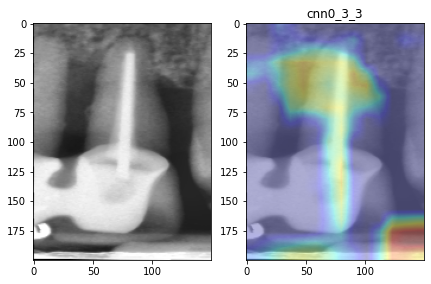

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-57-687_701509 061919 x_10_-4.png',)
truth = 3
predicted = 3
T/F = T


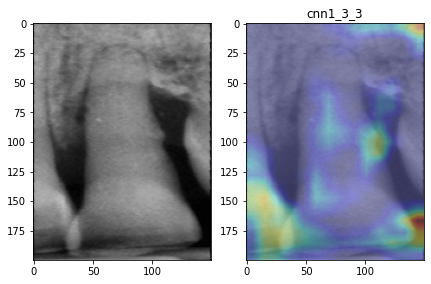

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-55-772_701509 061919 x_3_-6.png',)
truth = 3
predicted = 3
T/F = T


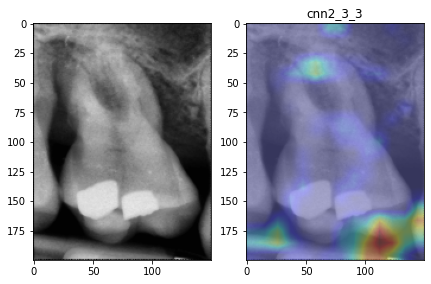

path = ('Dental_Data/PBL/10_clahe_20200810/05-42-53-756_704288 082619 x_12_-4.png',)
truth = 3
predicted = 1
T/F = F


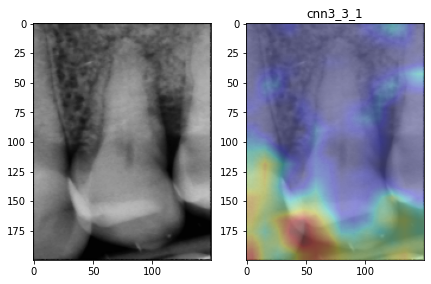

path = ('Dental_Data/PBL/10_clahe_20200810/05-38-44-768_684988 92118 x_28_1.png',)
truth = 1
predicted = 1
T/F = T


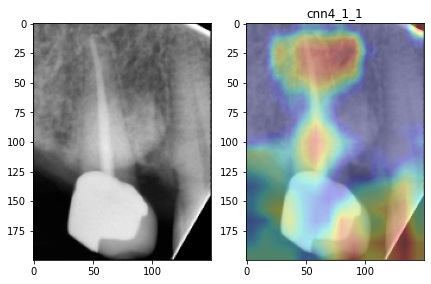

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-43-606_701436 060419 x_23_-9.png',)
truth = 3
predicted = 3
T/F = T


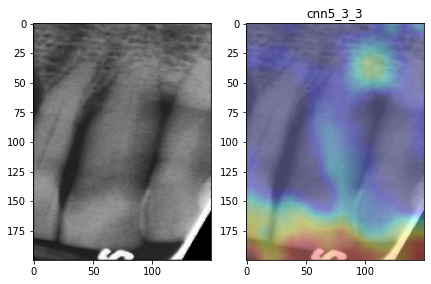

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-40-123_701436 060419 x_20_7.png',)
truth = 3
predicted = 3
T/F = T


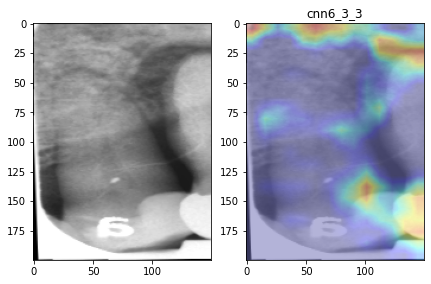

path = ('Dental_Data/PBL/10_clahe_20200810/05-39-13-197_685431 092418 x_24_-2.png',)
truth = 1
predicted = 2
T/F = F


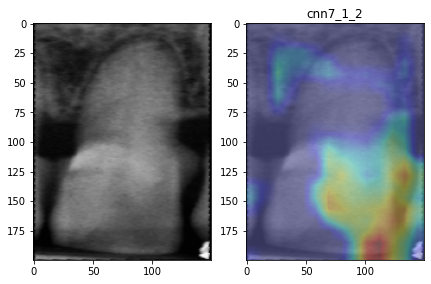

path = ('Dental_Data/PBL/10_clahe_20200810/05-42-33-154_702488 101019 x_27_-5.png',)
truth = 1
predicted = 1
T/F = T


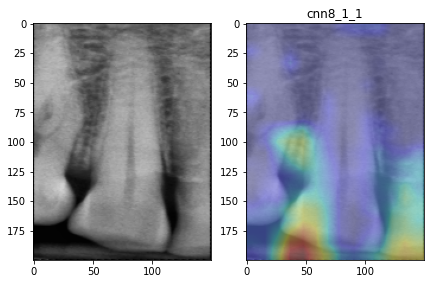

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-06-714_697216 041519 x_9_2.png',)
truth = 1
predicted = 1
T/F = T


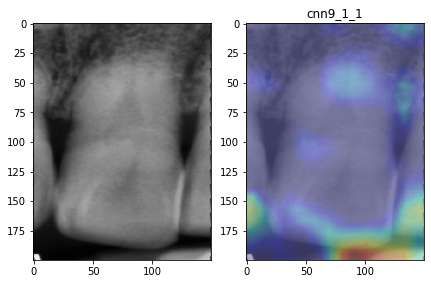

path = ('Dental_Data/PBL/10_clahe_20200810/05-37-11-516_681916 083118 x_11_-8.png',)
truth = 1
predicted = 3
T/F = F


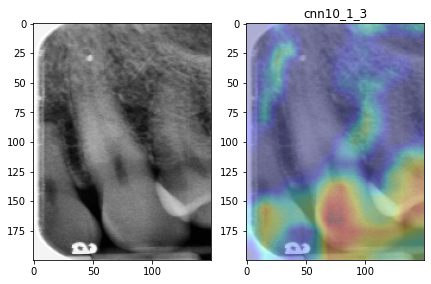

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-14-208_687595 091318 x_15_9.png',)
truth = 2
predicted = 3
T/F = F


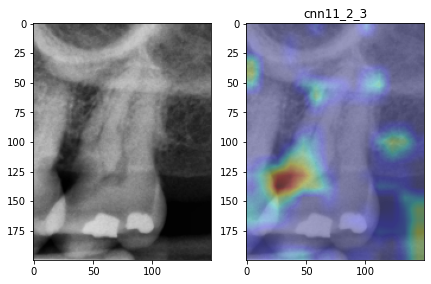

path = ('Dental_Data/PBL/10_clahe_20200810/05-39-27-680_685528 062519 x_18_-1.png',)
truth = 1
predicted = 1
T/F = T


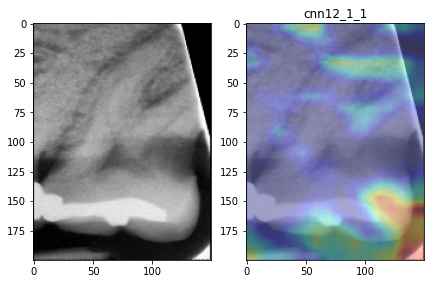

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-18-754_691806 111519 x_30_-6.png',)
truth = 2
predicted = 2
T/F = T


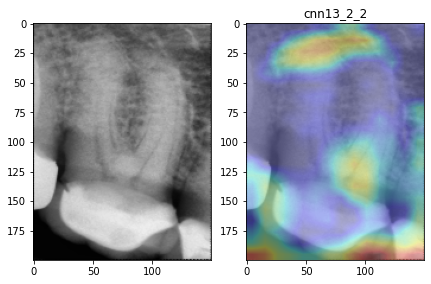

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-16-214_688247 091111318 x_14_-1.png',)
truth = 2
predicted = 1
T/F = F


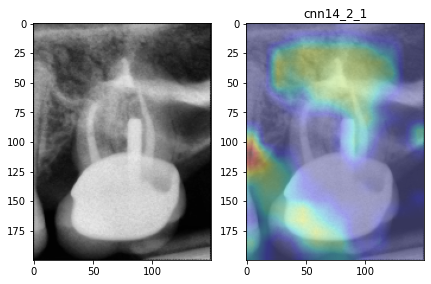

path = ('Dental_Data/PBL/10_clahe_20200810/05-39-40-422_686228 083018 x_2_-7.png',)
truth = 1
predicted = 2
T/F = F


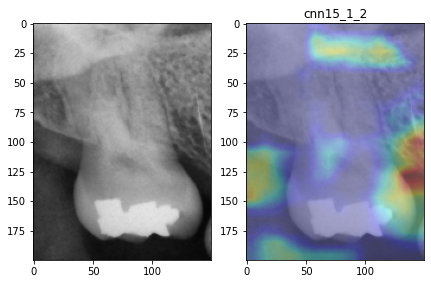

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-00-876_697216 041519 x_31_-5.png',)
truth = 2
predicted = 2
T/F = T


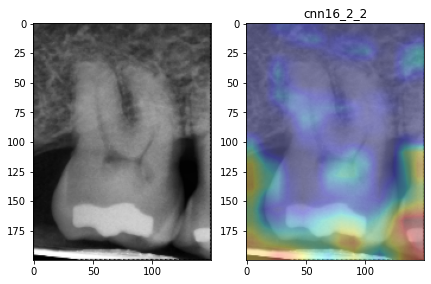

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-43-169_701436 060419 x_25_4.png',)
truth = 3
predicted = 3
T/F = T


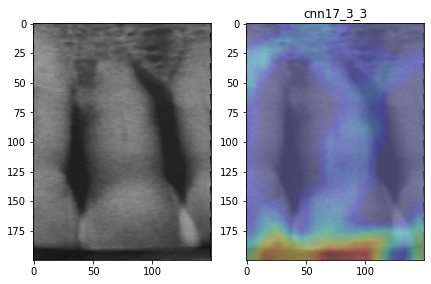

path = ('Dental_Data/PBL/10_clahe_20200810/05-42-33-728_702488 101019 x_31_6.png',)
truth = 1
predicted = 2
T/F = F


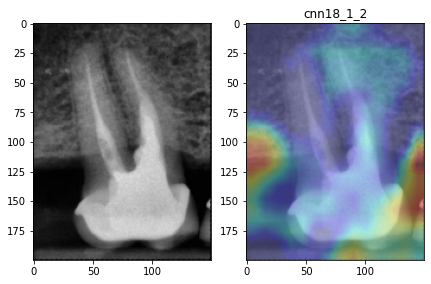

path = ('Dental_Data/PBL/10_clahe_20200810/05-36-45-685_681509 061218 x_9_-9.png',)
truth = 1
predicted = 2
T/F = F


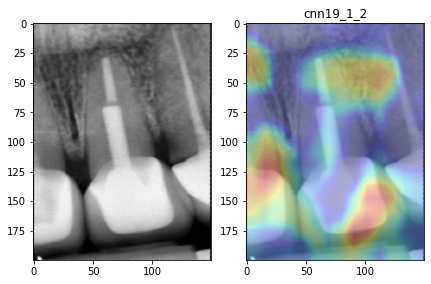

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-33-598_701371 061119 x_25_-1.png',)
truth = 3
predicted = 3
T/F = T


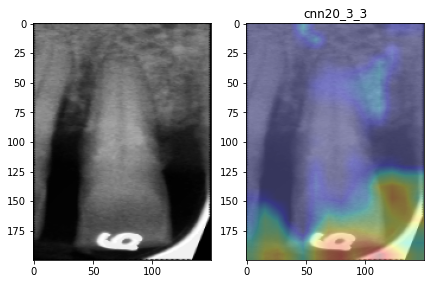

path = ('Dental_Data/PBL/10_clahe_20200810/05-36-33-477_679891 022719 x_8_-1.png',)
truth = 1
predicted = 1
T/F = T


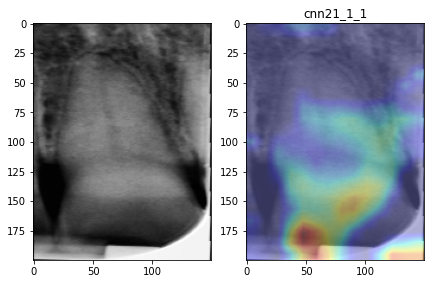

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-47-996_696537 030519 x_12_-3.png',)
truth = 2
predicted = 1
T/F = F


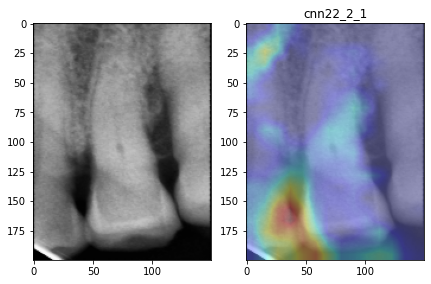

path = ('Dental_Data/PBL/10_clahe_20200810/05-36-44-440_681509 061218 x_13_-8.png',)
truth = 1
predicted = 1
T/F = T


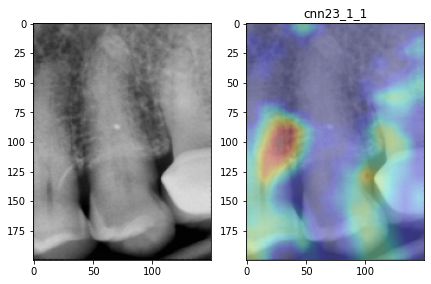

path = ('Dental_Data/PBL/10_clahe_20200810/05-42-18-180_701864 092319 x_22_-6.png',)
truth = 2
predicted = 2
T/F = T


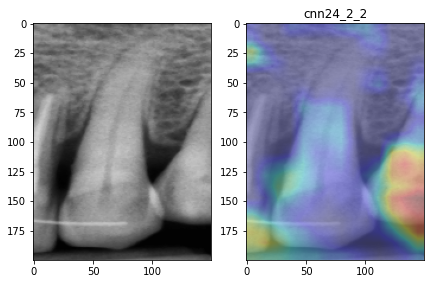

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-58-249_697009 061119 x_14_-4.png',)
truth = 2
predicted = 2
T/F = T


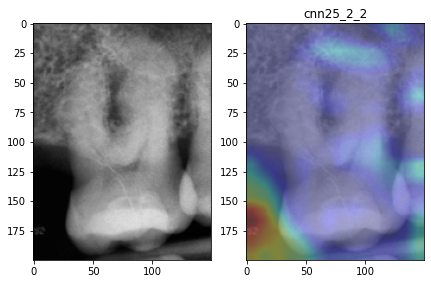

path = ('Dental_Data/PBL/10_clahe_20200810/05-38-18-515_684919 082918 x_22_-8.png',)
truth = 1
predicted = 1
T/F = T


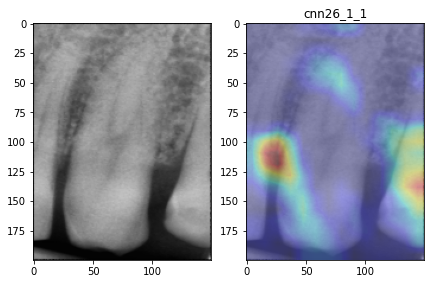

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-20-886_697467 031819 x_19_-2.png',)
truth = 2
predicted = 2
T/F = T


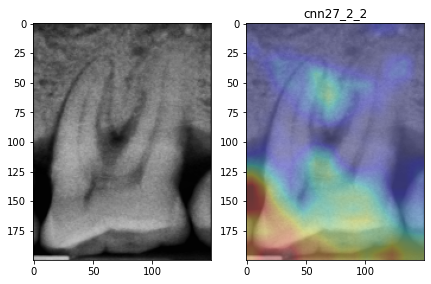

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-41-213_701436 060419 x_21_-5.png',)
truth = 2
predicted = 2
T/F = T


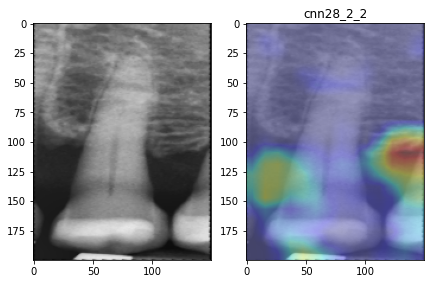

path = ('Dental_Data/PBL/10_clahe_20200810/05-36-39-931_681509 061218 x_3_9.png',)
truth = 1
predicted = 1
T/F = T


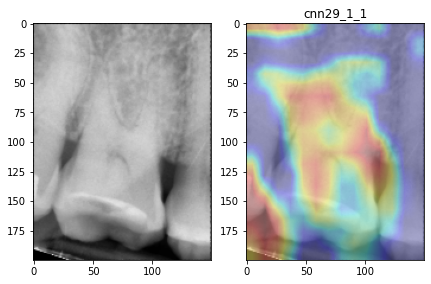

path = ('Dental_Data/PBL/10_clahe_20200810/05-38-23-327_684919 082918 x_11_6.png',)
truth = 1
predicted = 2
T/F = F


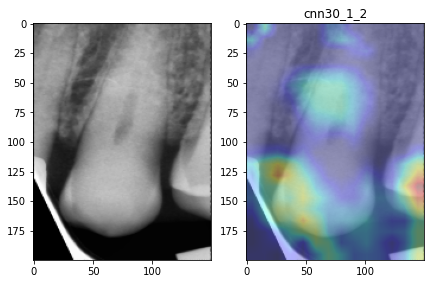

path = ('Dental_Data/PBL/10_clahe_20200810/05-44-07-934_710456 111119 x_24_9.png',)
truth = 3
predicted = 3
T/F = T


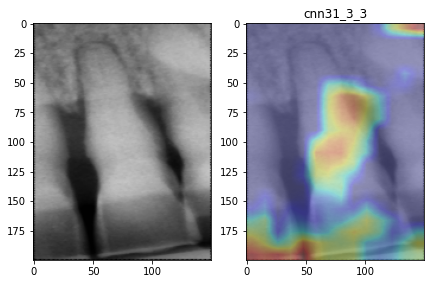

path = ('Dental_Data/PBL/10_clahe_20200810/05-42-16-876_701864 092319 x_26_9.png',)
truth = 3
predicted = 3
T/F = T


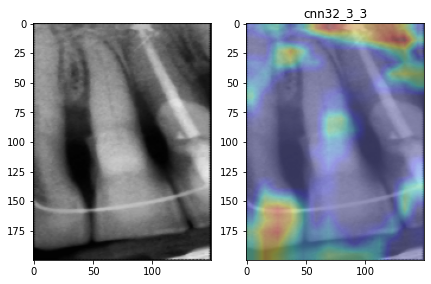

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-46-663_701436 060419 x_9_-10.png',)
truth = 3
predicted = 3
T/F = T


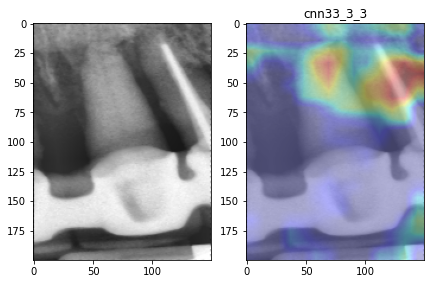

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-00-855_697216 041519 x_31_-6.png',)
truth = 2
predicted = 2
T/F = T


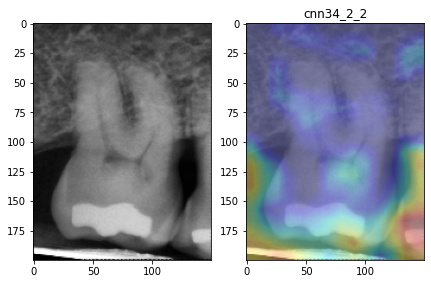

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-06-453_687595 091318 x_7_-2.png',)
truth = 2
predicted = 1
T/F = F


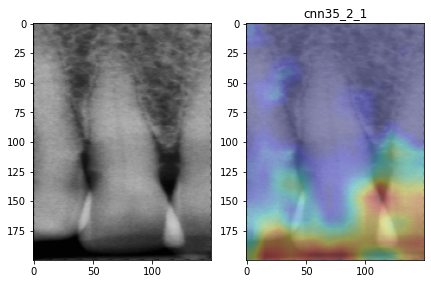

path = ('Dental_Data/PBL/10_clahe_20200810/05-42-17-427_701864 092319 x_24_2.png',)
truth = 3
predicted = 3
T/F = T


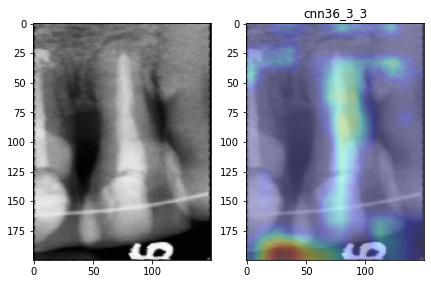

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-35-232_701371 061119 x_7_3.png',)
truth = 3
predicted = 3
T/F = T


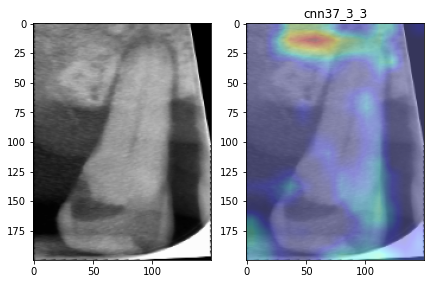

path = ('Dental_Data/PBL/10_clahe_20200810/05-44-13-463_710456 111119 x_14_7.png',)
truth = 3
predicted = 3
T/F = T


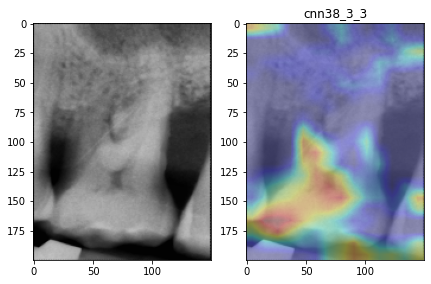

path = ('Dental_Data/PBL/10_clahe_20200810/05-37-08-974_681916 083118 x_31_-7.png',)
truth = 1
predicted = 1
T/F = T


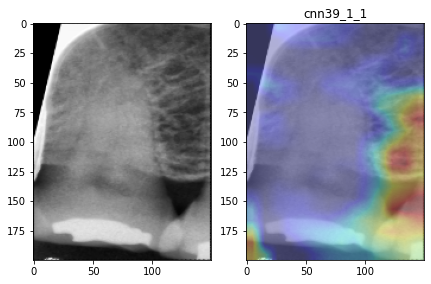

path = ('Dental_Data/PBL/10_clahe_20200810/05-44-05-359_710456 111119 x_10_1.png',)
truth = 3
predicted = 3
T/F = T


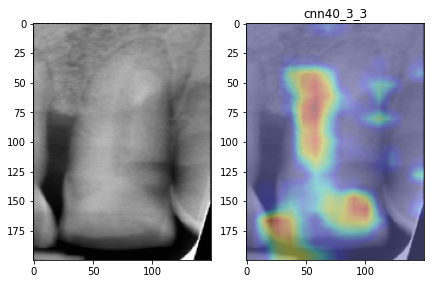

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-52-616_701509 061919 x_26_7.png',)
truth = 2
predicted = 3
T/F = F


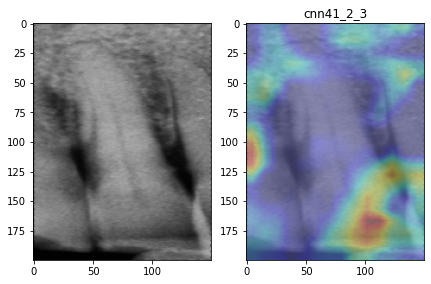

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-43-468_701436 060419 x_24_2.png',)
truth = 3
predicted = 3
T/F = T


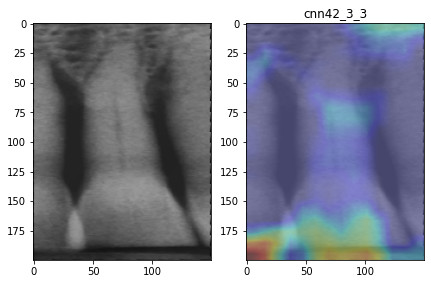

path = ('Dental_Data/PBL/10_clahe_20200810/05-37-31-279_682208 062018 x_19_-4.png',)
truth = 1
predicted = 1
T/F = T


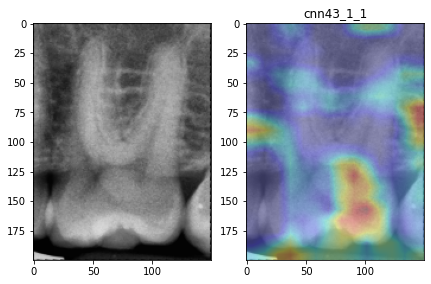

path = ('Dental_Data/PBL/10_clahe_20200810/05-42-54-484_704288 082619 x_13_5.png',)
truth = 3
predicted = 2
T/F = F


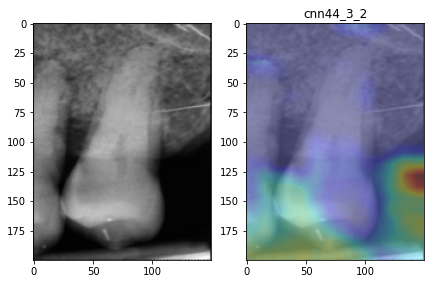

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-38-021_692260_2 120618 x_18_-2.png',)
truth = 2
predicted = 2
T/F = T


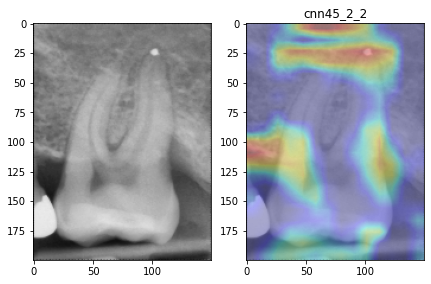

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-51-359_701509 061919 x_14_-7.png',)
truth = 3
predicted = 3
T/F = T


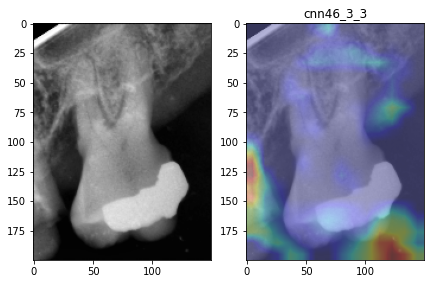

path = ('Dental_Data/PBL/10_clahe_20200810/05-43-41-571_707506 100419 x_28_-10.png',)
truth = 1
predicted = 1
T/F = T


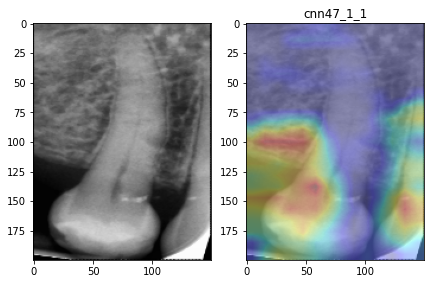

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-16-914_697467 031819 x_21_-3.png',)
truth = 2
predicted = 2
T/F = T


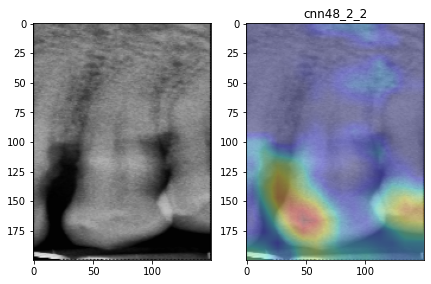

path = ('Dental_Data/PBL/10_clahe_20200810/05-43-14-821_705777 082819 x_28_-7.png',)
truth = 1
predicted = 1
T/F = T


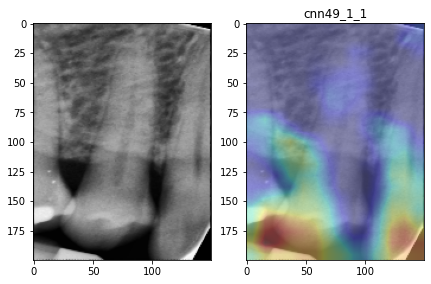

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-24-738_692260_1 100312 x_4_5.png',)
truth = 2
predicted = 2
T/F = T


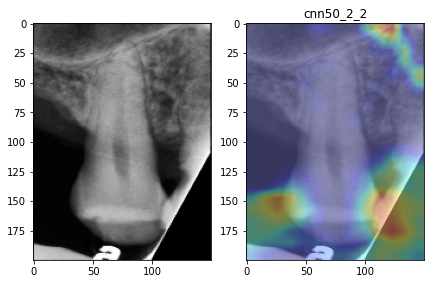

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-57-179_696537 030519 x_10_0.png',)
truth = 2
predicted = 2
T/F = T


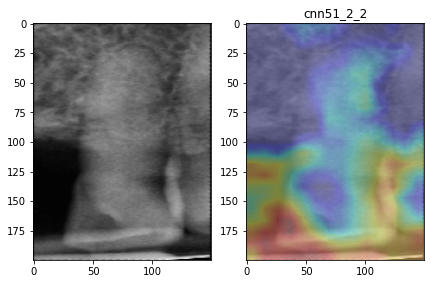

path = ('Dental_Data/PBL/10_clahe_20200810/05-39-54-459_686705 021419 x_14_-7.png',)
truth = 1
predicted = 2
T/F = F


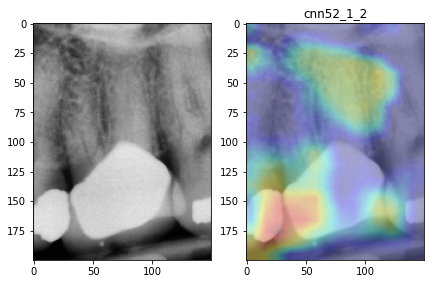

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-36-714_701371 061119 x_4_-6.png',)
truth = 2
predicted = 3
T/F = F


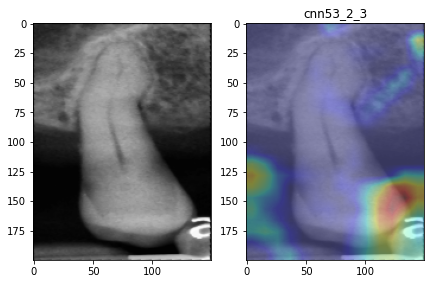

path = ('Dental_Data/PBL/10_clahe_20200810/05-38-41-444_684988 92118 x_28_-9.png',)
truth = 1
predicted = 1
T/F = T


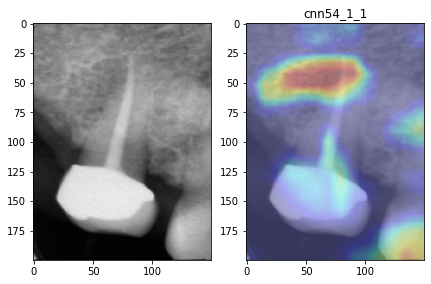

path = ('Dental_Data/PBL/10_clahe_20200810/05-42-06-044_701719 062519 x_26_-6.png',)
truth = 2
predicted = 2
T/F = T


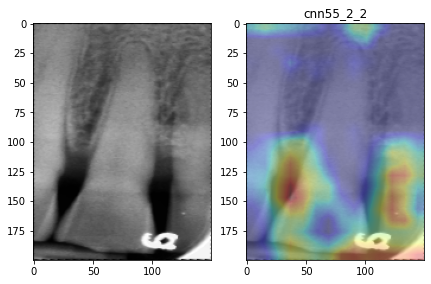

path = ('Dental_Data/PBL/10_clahe_20200810/05-41-58-946_701719 062519 x_2_6.png',)
truth = 2
predicted = 3
T/F = F


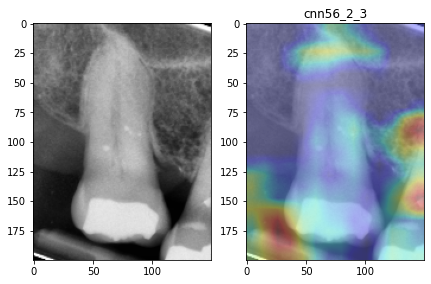

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-19-185_691806 111519 x_29_-6.png',)
truth = 1
predicted = 1
T/F = T


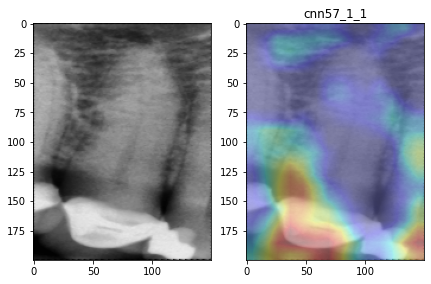

path = ('Dental_Data/PBL/10_clahe_20200810/05-40-00-150_686860 090518 x_21_8.png',)
truth = 2
predicted = 2
T/F = T


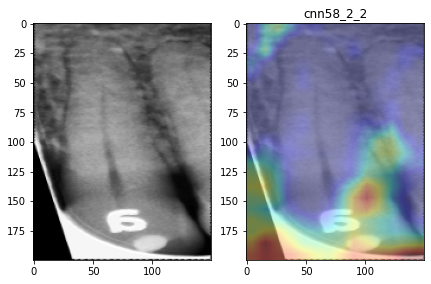

In [ ]:
%%time
for idx, data in tqdm(enumerate(testloader)):
    img, label, img_path = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.int64), data[2]
#     print('label =',label)
#     print('path  =',img_path[0])

    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(img).detach()
    for i in range(256):
        activations[:, i, :, :] *= pooled_gradients[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    #plt.matshow(heatmap.squeeze())
    #################pred
    output = model(img)
    max_value, predicted = torch.max(output.data, 1)
    print('path =',img_path)
    print('truth =',label.cpu().numpy()[0]+1)
    print('predicted =',predicted.cpu().numpy()[0]+1)
    if label.cpu().numpy()[0]+1 == predicted.cpu().numpy()[0]+1:
        print('T/F = T')
    else:
        print('T/F = F')
    #########################
    # print('heatmap shape =',np.shape(heatmap))
    # heatmap /= torch.max(heatmap)
    pred_class_name = 'cnn'+str(idx)+'_'+str(label.cpu().numpy()[0]+1)+'_'+str(predicted.cpu().numpy()[0]+1)
    plot_heatmap(heatmap.cpu().numpy(), img_path[0], label.cpu().numpy()[0], pred_class_name,pred_class_name)
        
        
        

In [ ]:
img_path

In [ ]:
path = '10_HV_interdental_clahe/03-30-48-822_704815 091819 x_13_6_L.png'
img = PIL.Image.open(path).convert('RGB')
img

In [ ]:
new_size = (100,200)
trans_method = [
    #transforms.Resize(new_size),
    #transforms.RandomVerticalFlip(p=1),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.ToPILImage()
]
trans = transforms.Compose(trans_method)
img2 = trans(img)
img2

In [ ]:
new_size = (100,200)
trans_method = [
    transforms.Resize(new_size),
    transforms.RandomVerticalFlip(p=1),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.ToPILImage()
]
trans = transforms.Compose(trans_method)
img2 = trans(img)
img2

In [ ]:
new_size = (150,80)
img_path = 'D:/Lab/PBL/HV/10_HV_interdental_clahe/02-20-37-721_000408 102419 x_6_-10_R.png'
img = PIL.Image.open(img_path).convert('RGB')
trans_method = [
    transforms.Resize(new_size),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.ToPILImage()
]
transform = transforms.Compose([
    transforms.Resize(new_size),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.ToPILImage()
])
new_img = transform(img)
new_img